# Simple Trading Rule

In [2]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
import matplotlib.pyplot as plt
%matplotlib inline

Work up a minimum example of a trend following system

Let's get some data

We can get data from various places; however for now we're going to use
prepackaged 'legacy' data stored in csv files

In [3]:
data = csvFuturesSimData()
data

No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


csvFuturesSimData object with 46 instruments

We get stuff out of data with methods

In [4]:
print(data.get_instrument_list())
print(data.get_raw_price("EDOLLAR").tail(5))

['AEX', 'AUD', 'BITCOIN', 'BOBL', 'BTP', 'BUND', 'CAC', 'COPPER', 'CORN', 'CRUDE_W', 'CRUDE_W_mini', 'EDOLLAR', 'EUR', 'EUROSTX', 'GAS_US', 'GAS_US_mini', 'GBP', 'GOLD', 'GOLD_micro', 'JPY', 'KOSPI', 'KOSPI_mini', 'KR10', 'KR3', 'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ', 'NASDAQ_micro', 'NZD', 'OAT', 'PALLAD', 'PLAT', 'SHATZ', 'SMI', 'SOYBEAN', 'SP500', 'SP500_micro', 'US-REALESTATE', 'US10', 'US2', 'US20', 'US5', 'V2X', 'VIX', 'WHEAT']
index
2021-03-08 16:00:00    98.865
2021-03-08 17:00:00    98.860
2021-03-08 18:00:00    98.865
2021-03-08 19:00:00    98.865
2021-03-08 20:00:00    98.860
Name: price, dtype: float64


data can also behave in a dict like manner (though it's not a dict)

In [5]:
data['SP500']

index
1997-12-12 23:00:00    1081.25
1997-12-15 23:00:00    1089.25
1997-12-16 23:00:00    1095.25
1997-12-17 23:00:00    1089.25
1997-12-18 23:00:00    1079.25
                        ...   
2021-03-08 17:00:00    3869.50
2021-03-08 18:00:00    3845.50
2021-03-08 19:00:00    3849.75
2021-03-08 20:00:00    3820.00
2021-03-08 21:00:00    3822.50
Name: price, Length: 16153, dtype: float64

In [6]:
data.keys()

['AEX',
 'AUD',
 'BITCOIN',
 'BOBL',
 'BTP',
 'BUND',
 'CAC',
 'COPPER',
 'CORN',
 'CRUDE_W',
 'CRUDE_W_mini',
 'EDOLLAR',
 'EUR',
 'EUROSTX',
 'GAS_US',
 'GAS_US_mini',
 'GBP',
 'GOLD',
 'GOLD_micro',
 'JPY',
 'KOSPI',
 'KOSPI_mini',
 'KR10',
 'KR3',
 'LEANHOG',
 'LIVECOW',
 'MXP',
 'NASDAQ',
 'NASDAQ_micro',
 'NZD',
 'OAT',
 'PALLAD',
 'PLAT',
 'SHATZ',
 'SMI',
 'SOYBEAN',
 'SP500',
 'SP500_micro',
 'US-REALESTATE',
 'US10',
 'US2',
 'US20',
 'US5',
 'V2X',
 'VIX',
 'WHEAT']

... however this will only access prices
(note these prices have already been backadjusted for rolls)

We have extra futures data here

In [7]:
data.get_instrument_raw_carry_data("EDOLLAR").tail(6)

,PRICE,CARRY,PRICE_CONTRACT,CARRY_CONTRACT
index,,,,
2021-03-08 15:00:00,98.865,99.015,20231200,20230900
2021-03-08 16:00:00,98.865,99.020,20231200,20230900
2021-03-08 17:00:00,98.860,99.015,20231200,20230900
2021-03-08 18:00:00,98.865,99.020,20231200,20230900
2021-03-08 19:00:00,98.865,99.015,20231200,20230900
2021-03-08 20:00:00,98.860,99.010,20231200,20230900


Technical note: csvFuturesSimData inherits from FuturesData which itself inherits from simData
The chain is 'data specific' <- 'asset class specific' <- 'generic'

Let's create a simple trading rule

No capping or scaling

In [4]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    # price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paper.systems.crypto_system import perpetuals_system
from itables import show
def select(se, start, end):
    return se[(se.index >= start) &(se.index <= end)]


system = perpetuals_system(config='paper.systems.production.yaml')
data = system.data

instrument_code = 'BTC-USDT-SWAP'
price = data.hourly_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 4, 16)
ewmac.columns = ['forecast']
show(ewmac.tail(7 * 24))

2023-02-24 15:36:48 {'type': 'base_system', 'stage': 'config'}  Adding config defaults


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


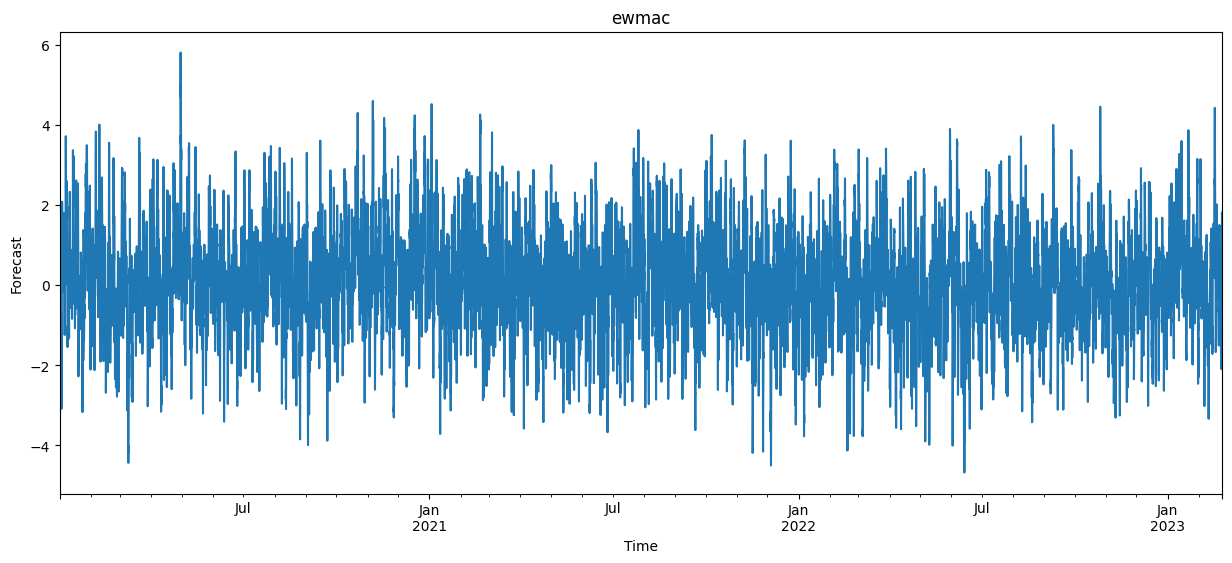

In [34]:
ewmac.plot(figsize=(15, 6))
plt.title('ewmac')
_ = plt.ylabel('Forecast')
_ = plt.xlabel('Time')
show(ewmac.abs().describe())

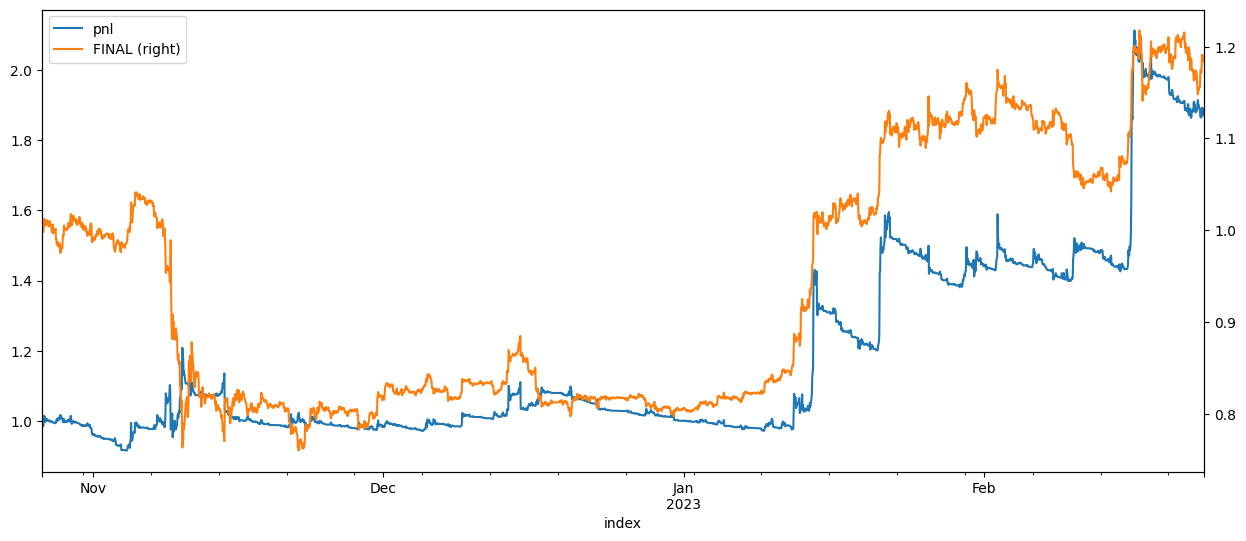

<AxesSubplot:xlabel='index'>

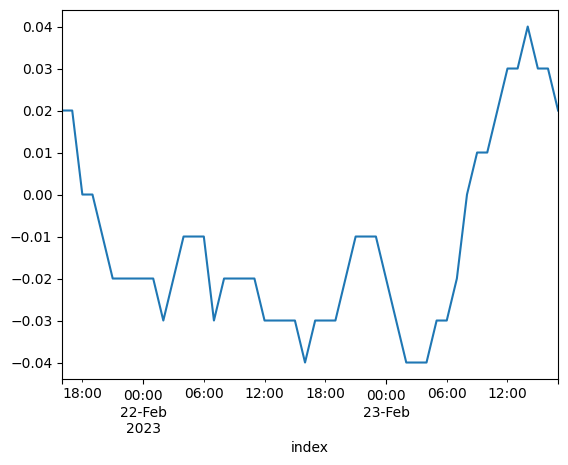

In [41]:

from systems.accounts.account_forecast import pandl_for_instrument_forecast

capital = 500
value_per_point = 1
risk_target = 0.5
target_abs_forecast = 1
vol, position, account = pandl_for_instrument_forecast(
    forecast=ewmac,
    price = price,
    capital = capital,
    value_per_point=value_per_point,
    risk_target = risk_target,
    target_abs_forecast = target_abs_forecast,
    SR_cost=0.1,
    delayfill=True
    )
position = position.round(2)

n_hours = 4 * 30 * 24
pnl = (position.shift(1) * price.diff()).tail(n_hours).rename('pnl') # .cumsum().plot(figsize=(15, 6), legend=True)
pct_panl = pnl / capital
(1 + pct_panl).cumprod().plot(figsize=(15, 6), legend=True)
(price.iloc[-n_hours:] / price.iloc[-n_hours]).plot(figsize=(15, 6), legend=True, secondary_y=True)
plt.show()

show(position.shift(1).tail(50))
position.shift(1).round(2).tail(50).plot()
# vol = vol.rename('vol')
# position = position.rename('position')
# price.tail(24 * 10).plot(figsize=(15, 6), legend=True)
# (price*position).tail(24 * 10).plot(secondary_y=True, legend=True)
# plt.axhline(y=0, linewidth=2, color='r')
# plt.axhline(y=2000, linewidth=2, color='r')

# from syscore.pandas.frequency import resample_prices_to_business_day_index
# show(price)
# show(resample_prices_to_business_day_index(price).diff())
# account.curve().plot()
# plt.title('Profit and Loss')
# plt.ylabel('PnL')
# plt.xlabel('Time')

In [43]:
24457.6 - 24567.7

(24581.6 - 22092.7) / 22092.7

0.11265712203578547

In [14]:
account.percent.stats()

[[('min', '-17.78'),
  ('max', '13.16'),
  ('median', '0'),
  ('mean', '0.006524'),
  ('std', '0.4496'),
  ('skew', '0.248'),
  ('ann_mean', '56.53'),
  ('ann_std', '41.85'),
  ('sharpe', '1.351'),
  ('sortino', '1.611'),
  ('avg_drawdown', '-10.88'),
  ('time_in_drawdown', '0.986'),
  ('calmar', '1.906'),
  ('avg_return_to_drawdown', '5.198'),
  ('avg_loss', '-0.198'),
  ('avg_gain', '0.2215'),
  ('gaintolossratio', '1.119'),
  ('profitfactor', '1.068'),
  ('hitrate', '0.4884'),
  ('t_stat', '2.41'),
  ('p_value', '0.01597')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

/opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='index'>

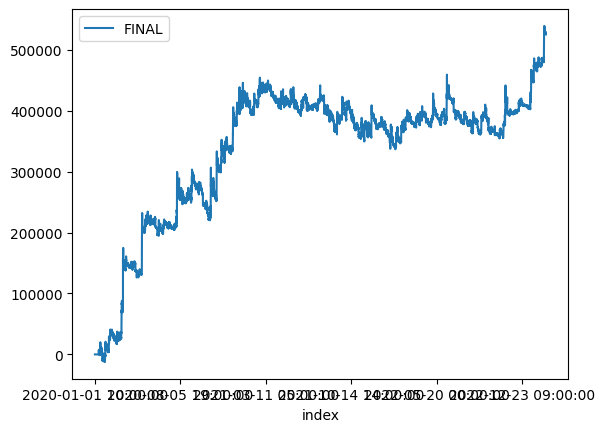

In [8]:
import pandas as pd
csv = pd.read_csv(r'/Users/weiranzhou/Code/pysystemtrade/test.csv', index_col=0)
csv.cumsum().plot()